# Support Vector Machines
[History of Support Vector Machines from Patrick Winston](https://youtu.be/_PwhiWxHK8o?t=2777)

$$ \text{Do not find a hyperplane, but find a hyperplane that maximizes the margin} $$



### Setup

$$ \mathcal D = \{(x_i,y_i)\}_{i=1} ^n$$

### What is a hyperplane 
A hyperplane is a set of data points $\mathcal H({w,b} )={x: w^T x + b =0}$.

### What is the margin given a hyperplane
To find a margin, we firstly need to be able to compute the distance of a point to the hyperplane

1. $\vec w \vec x + b = 0$
2. Let $\vec x_p$ be a point whose distance to $H_{w,b}$ we want to compute: $\vec x_p = \vec x - \vec d$, where $\vec x \in H_{w,b}$
3. $\vec w (\vec x - \vec d) +b = 0$
4. $\vec d= \alpha \vec w$ because d should be paralel to w.


#### Finding $\alpha$
$$ \vec w (\vec x - \alpha \vec w) +b = 0 \implies \alpha = \frac{w^T x + b}{w^T w}$$

#### Finding distance $\vec d$
$$ \vec d = \frac{w^T x + b}{w^T w} * \vec w$$


#### Finding margin $\gamma(w,b,\mathcal D)$

$$ \gamma(w,b,\mathcal D) = min \frac{|w^t x +b|}{w^T w}$$

# SVM objective


### 1. $$ max_{w,b} =  \gamma(w,b,\mathcal D) \; \text{ s.t. } \\ \forall (x_i,y_i) \in \mathcal D: y_i (w^T x_i +b) \ge 0$$



### 2. $$ max_{w,b} =  \frac{1}{||w||_2} \Big[ min_x |w^t x +b| \Big] \; \text{ s.t. } \\ \forall (x_i,y_i) \in \mathcal D: y_i (w^T x_i +b) \ge 0$$

$w$ is not a function of x. Hence, we can take it out.



### 3. $$ min_{w,b} =  ||w||_2 \Big[ min_x |w^t x +b| \Big] \; \text{ subject to } \\ \forall (x_i,y_i) \in \mathcal D: y_i (w^T x_i +b) \ge 0$$

Instead of maximizing with respect to 1/w, minimize w

# 4. $$ min_{w,b} =  ||w||_2 \\ \text{ subject to } \\ \forall i, y_i (w^T x_i +b) \ge 0 \\ \text{and} \\  min_i |w^T x_i +b|=1$$


__Scale Invariance of the margin comes to rescue__ $\gamma(w,b,\mathcal D)=\gamma(\beta w,\beta,\mathcal D) \forall \beta>0$. 


# 5. $$ min_{w,b} =  ||w||_2 \\ \text{ subject to } \\ \forall i, y_i (w^T x_i +b) \ge 1$$


We have a quadratic optimization problem, i.e,. The objective is quadratic and the constraints are linear

### SVM Primal Objective as a Quadratic Optimization Problem
$$ min_{w,b} =  ||w||_2 \\ \text{ subject to } \\ \forall i, y_i (w^T x_i +b) \ge 1$$


We have a quadratic optimization problem, i.e,. The objective is quadratic and the constraints are linear



### SVM Dual Objective


$$ min_{\alpha_1, \dots, \alpha_n} \frac{1}{2} \sum_i ^n \sum_j ^n \alpha_i \alpha_j y_i y_j K_{ij} - \sum_i ^n \alpha_i \\ \text{subject to } \\
\sum_i ^n \alpha_i y_i = 0 \;: \; \alpha_i \ge 0
$$
$$ w = \sum_i ^n \alpha_i y_i x_i $$
$$ b = y_i - \sum_j ^n \alpha_j y_j x_j^T x_i  \; \text{ for all } \alpha_i > 0$$

Langrangian Karush-Kuhn-Tucker (KKT) Dual Formulation. $K$ stands for the kernel matrix.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
import cvxopt
import cvxopt.solvers
from sklearn.preprocessing import LabelEncoder
np.random.seed(1)

In [2]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)
def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p
def gaussian_kernel(x, y, sigma=.01):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))
def exponential_kernel(a,b,sigma=.2,mu=0):
    x=a-b
    return np.exp(-0.5 * ( 1/(2*np.power(sigma,2)) ) * ( np.power(x-mu,2)))
def laplacian_kernel(a,b,sigma=.2,mu=0):
    x=a-b
    return np.exp(-0.5 * ( 1/(2*np.power(sigma,2)) ) * ( np.abs(x-mu)))

     pcost       dcost       gap    pres   dres
 0: -1.6196e+00 -2.3278e+00  1e+02  1e+01  1e+00
 1: -2.1527e-01 -1.0917e-01  5e+00  5e-01  7e-02
 2:  1.7754e-03 -8.9952e-02  1e-01  5e-03  7e-04
 3: -2.1135e-02 -3.9134e-02  2e-02  1e-17  5e-16
 4: -3.0289e-02 -3.4529e-02  4e-03  4e-18  3e-16
 5: -3.3299e-02 -3.4296e-02  1e-03  2e-17  3e-16
 6: -3.4151e-02 -3.4163e-02  1e-05  8e-18  4e-16
 7: -3.4161e-02 -3.4161e-02  1e-07  7e-18  4e-16
 8: -3.4161e-02 -3.4161e-02  1e-09  1e-17  4e-16
Optimal solution found.
2 support vectors out of 50 points


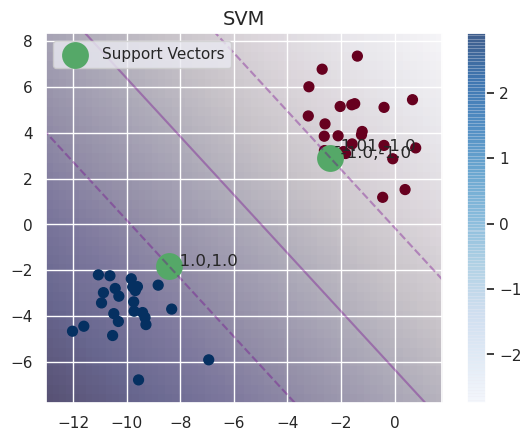

In [3]:
class SVM_QP:
    """ Maximum margin classifier - Support Vector Machines 
    as a quadratic optimization problem
    
    min_{w,b}   ||w||_2 subject to \forall y_i (w^T x_i + b) >= 1
    
    cvxopt usage from (https://gist.github.com/mblondel/586753)
    """
    
    def __init__(self,kernel=linear_kernel,C=None):
        self.C=C
        self.kernel=kernel
 
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Dot product between each and every pair of inputs
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = linear_kernel(X[i], X[j])
                
        # Solves a quadratic program
        """
        minimize    (1/2)*a'*P*a + q'*a
        subject to  G*a <= h
                    A*a = b.
                    
        P = (\sum_i \sum_j a_i a_j y_i y_j x_i^T x_j) 
        q = -\sum_i x_i
        
        G= \forall i a_i >= 0 (NO SLACK)
        """
        P = cvxopt.matrix(np.outer(y,y) * K)
        # -|a|
        q= cvxopt.matrix(np.ones(n_samples) * -1)
        
        """ (1) Linear Constraint  : Inner product of alpha with labels should be 0 """ 
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        
        if self.C is None:
            # If there are no slack variables
            """ (2.1) Linear Constraint  : every alpha is positive """ 
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            # If there are slack variables
            """ (2.2) Linear Constraint  : every alpha is between 0 or C""" 
            G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        solution = cvxopt.solvers.qp(P, q, 
                                     G, h, 
                                     A, b)
        # Lagrange multipliers
        a = np.ravel(solution['x'])
        
        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print ("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
            
        if len(self.a)>0:
            self.b /= len(self.a)
    
        # Weight vector
        self.w = np.zeros(n_features)
        for n in range(len(self.a)):
            self.w += self.a[n] * self.sv_y[n] * self.sv[n]
            
        return self

    def project(self, X):
        return np.dot(X, self.w) + self.b
    
    def predict(self, X):
        return np.sign(self.project(X))
    
    def plot_decision_boundary(self,X,y,plot_support_vector=False):
        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], c=y, s=50,cmap='RdBu')
        ax.set_title(f'SVM', size=14)
        
        xx_min,xy_min=X.min(axis=0)
        xx_max,xy_max=X.max(axis=0)

        # Visualization works perfectly
        xlim,ylim = (xx_min-1, xx_max+1), (xy_min-1, xy_max+1)
        xg = np.linspace(xlim[0], xlim[1], 60)
        yg = np.linspace(ylim[0], ylim[1], 40)
        xx, yy = np.meshgrid(xg, yg)
        Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T
        for label, color in enumerate(['red', 'blue']):
            Pm=self.project(Xgrid)
            c=ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,cmap=color.title() + 's')
            ax.contour(xx, yy, Pm.reshape(xx.shape),levels=[-1,0,1],
                       colors=color,linestyles=['--', '-', '--'],alpha=0.2)
        fig.colorbar(c, ax=ax)
        ax.set(xlim=xlim, ylim=ylim)

        if plot_support_vector:
            plt.scatter(self.sv[:, 0],self.sv[:, 1],s=300, linewidth=2, facecolors='g',label='Support Vectors');

            pred=self.project(X)
            for i in range(len(X)):
                if -1.1<pred[i]<1.1:
                    plt.annotate(f'  {pred[i]:.3},{y[i]}',xy=(X[i]))
            plt.legend()
        plt.show()
    
    
X, y = make_blobs(50, 2, centers=2, random_state=1, cluster_std=1.4)
y[y==0]=-1.0
y=y.astype(np.float64)
clr=SVM_QP().fit(X,y)
clr.plot_decision_boundary(X,y,plot_support_vector=True)

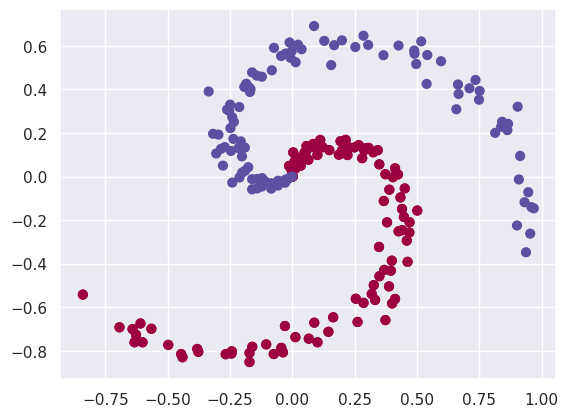

(200, 2) (200,)
float64 float64
     pcost       dcost       gap    pres   dres
 0: -1.1582e+02 -3.1145e+02  7e+02  2e+01  3e+00
 1: -4.5641e+02 -6.7922e+02  4e+02  1e+01  1e+00
 2: -1.7263e+03 -2.1551e+03  4e+02  8e+00  1e+00
 3: -5.0860e+03 -5.8647e+03  8e+02  8e+00  1e+00
 4: -3.9034e+04 -3.9754e+04  7e+02  7e+00  1e+00
 5: -1.7356e+06 -1.7425e+06  7e+03  7e+00  1e+00
 6: -3.7892e+08 -3.7912e+08  2e+05  7e+00  1e+00
 7: -4.1977e+11 -4.1986e+11  9e+07  7e+00  1e+00
 8: -4.8013e+11 -4.8024e+11  1e+08  7e+00  1e+00
 9: -6.2787e+11 -6.2800e+11  1e+08  7e+00  1e+00
10: -2.6002e+12 -2.6007e+12  6e+08  7e+00  1e+00
Terminated (singular KKT matrix).
200 support vectors out of 200 points


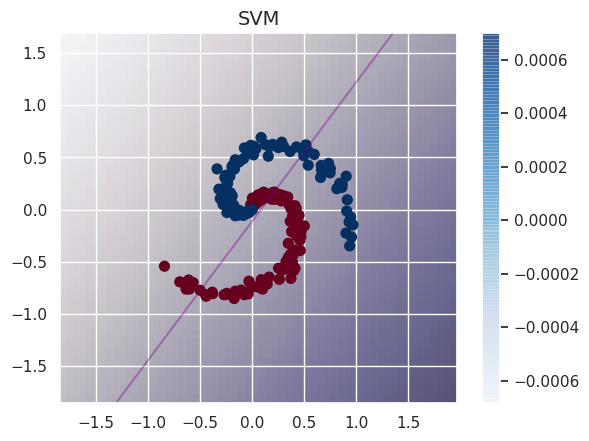

0.285

In [4]:
def spiral_data_gen(N=100,D=2,K=2):
    """
    N: number of points per class
    D:dimensionality
    K:number of classes
    """
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K) # class labels
    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1,N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
        # lets visualize the data:
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()
    y[y==0]=-1
    return X,y
X,y=spiral_data_gen()
print(X.shape, y.shape)
print(X.dtype, y.dtype)
clr=SVM_QP().fit(X,y)
clr.plot_decision_boundary(X,y) # No solution found
(clr.predict(X)==y).mean()

## $$ \text{Poor performance if data is not linearly separable} $$

## SVM Primal  Objective with Slack Variables

$$ min_{w,b} =  ||w||_2 + C \sum_i ^n \xi_i \\ \text{ subject to } \\ \forall i, y_i (w^T x_i +b) \ge 1- \xi_i \\
\xi_i \ge 0
$$

The slack variable $\xi_i$ allows $x_i$ to be closer to the hyperplane (or even be on the wrong side). If C is large, the SVM becomes very strict. If C is small, the loss inccured due to $\xi_i$ ignred to obtain simler solution


## SVM Dual Objective with Slack Variable


$$ min_{\alpha_1, \dots, \alpha_n} \frac{1}{2} \sum_i ^n \sum_j ^n \alpha_i \alpha_j y_i y_j K_{ij} - \sum_i ^n \alpha_i \\ \text{subject to } \\
\sum_i ^n \alpha_i y_i = 0 \;: \; \alpha_i \in [0,C]
$$
$$ w = \sum_i ^n \alpha_i y_i x_i $$
$$ b = y_i - \sum_j ^n \alpha_j y_j x_j^T x_i  \; \text{ for all } \alpha_i > 0$$

Langrangian Karush-Kuhn-Tucker (KKT) Dual Formulation. $K$ stands for the kernel matrix.

     pcost       dcost       gap    pres   dres
 0: -1.1483e+02 -4.4855e+02  2e+03  2e+00  2e-15
 1: -8.0778e+01 -2.8332e+02  2e+02  6e-02  1e-15
 2: -9.3909e+01 -1.2755e+02  3e+01  9e-03  1e-15
 3: -1.0352e+02 -1.1303e+02  1e+01  2e-03  1e-15
 4: -1.0675e+02 -1.0898e+02  2e+00  2e-14  1e-15
 5: -1.0757e+02 -1.0792e+02  3e-01  2e-14  1e-15
 6: -1.0770e+02 -1.0774e+02  3e-02  4e-14  1e-15
 7: -1.0772e+02 -1.0772e+02  7e-04  2e-14  1e-15
 8: -1.0772e+02 -1.0772e+02  7e-06  9e-16  1e-15
Optimal solution found.
113 support vectors out of 200 points


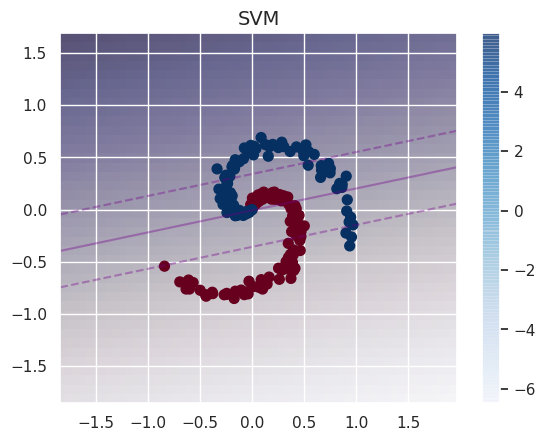

0.725

In [5]:
clr=SVM_QP(C=1.).fit(X,y)
clr.plot_decision_boundary(X,y) # No solution found
(clr.predict(X)==y).mean()

## $$ \text{Better performance than using hard constriants} $$

     pcost       dcost       gap    pres   dres
 0: -5.2010e+02 -1.0826e+04  2e+04  3e-01  9e-15
 1: -5.9082e+02 -2.0966e+03  2e+03  1e-02  7e-15
 2: -8.1910e+02 -1.3033e+03  5e+02  3e-03  8e-15
 3: -8.9672e+02 -1.2127e+03  3e+02  2e-03  7e-15
 4: -9.3829e+02 -1.1563e+03  2e+02  1e-03  8e-15
 5: -9.6299e+02 -1.1262e+03  2e+02  7e-04  7e-15
 6: -9.8667e+02 -1.0920e+03  1e+02  4e-04  8e-15
 7: -1.0013e+03 -1.0704e+03  7e+01  2e-04  8e-15
 8: -1.0221e+03 -1.0423e+03  2e+01  4e-05  1e-14
 9: -1.0303e+03 -1.0324e+03  2e+00  3e-06  1e-14
10: -1.0311e+03 -1.0314e+03  2e-01  2e-07  1e-14
11: -1.0312e+03 -1.0313e+03  1e-02  7e-09  1e-14
12: -1.0313e+03 -1.0313e+03  1e-04  7e-11  1e-14
Optimal solution found.
105 support vectors out of 200 points


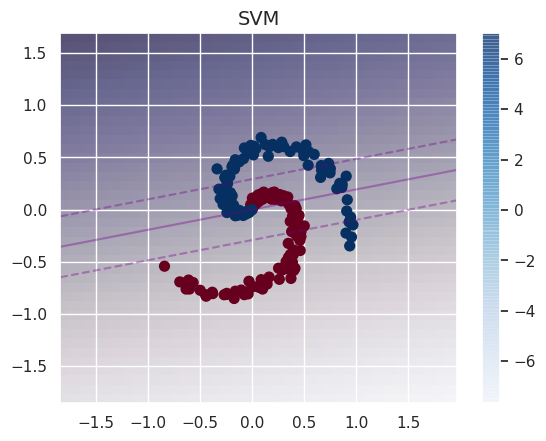

0.705

In [6]:
clr=SVM_QP(C=10).fit(X,y)
clr.plot_decision_boundary(X,y) # No solution found
(clr.predict(X)==y).mean()

     pcost       dcost       gap    pres   dres
 0:  5.4599e+03 -8.2941e+05  1e+06  2e-01  8e-14
 1: -1.7291e+03 -9.5985e+04  1e+05  9e-03  7e-14
 2: -6.3660e+03 -1.9595e+04  1e+04  1e-03  6e-14
 3: -8.1036e+03 -1.4410e+04  6e+03  4e-04  6e-14
 4: -8.7651e+03 -1.3089e+04  4e+03  2e-04  8e-14
 5: -9.1319e+03 -1.2278e+04  3e+03  1e-04  7e-14
 6: -9.4485e+03 -1.1678e+04  2e+03  9e-05  7e-14
 7: -9.6687e+03 -1.1271e+04  2e+03  5e-05  8e-14
 8: -9.9066e+03 -1.0832e+04  9e+02  2e-05  9e-14
 9: -1.0012e+04 -1.0616e+04  6e+02  1e-05  7e-14
10: -1.0139e+04 -1.0410e+04  3e+02  2e-06  8e-14
11: -1.0238e+04 -1.0276e+04  4e+01  1e-08  9e-14
12: -1.0253e+04 -1.0259e+04  6e+00  2e-09  9e-14
13: -1.0255e+04 -1.0256e+04  6e-01  9e-11  9e-14
14: -1.0256e+04 -1.0256e+04  7e-03  5e-12  1e-13
Optimal solution found.
199 support vectors out of 200 points


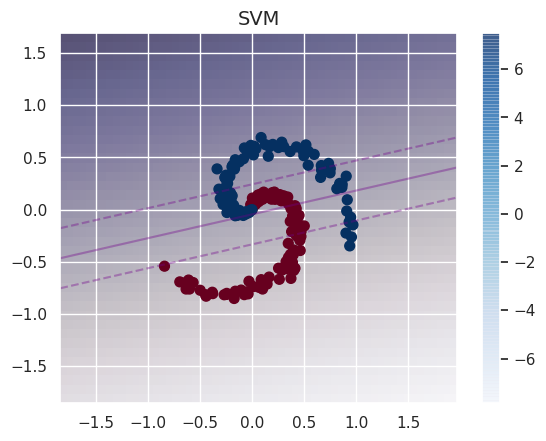

0.77

In [7]:
clr=SVM_QP(C=100).fit(X,y)
clr.plot_decision_boundary(X,y) # No solution found
(clr.predict(X)==y).mean()

## SVM Prime Objective with Slack Variable as an Unconstrainted objective formulation

$$ min_{w,b} w^T w + C \sum_i ^n max \Big[ 1- y_i(w^T x_i + b),0 \Big] $$

We can find $w,b$ through __gradient descent__.

Loss:5775.0 ||w||_2=1.129, Acc:0.4
Loss:0.70924 ||w||_2=0.709, Acc:1.0
Loss:0.682 ||w||_2=0.665, Acc:1.0
Loss:0.62795 ||w||_2=0.628, Acc:1.0
Loss:0.59691 ||w||_2=0.597, Acc:1.0
Loss:0.57136 ||w||_2=0.571, Acc:1.0
Loss:0.55272 ||w||_2=0.553, Acc:1.0
Loss:0.53535 ||w||_2=0.535, Acc:1.0
Loss:0.5218 ||w||_2=0.522, Acc:1.0
Loss:0.50992 ||w||_2=0.510, Acc:1.0
Loss:0.50246 ||w||_2=0.502, Acc:1.0
Loss:0.49425 ||w||_2=0.494, Acc:1.0
Loss:0.48739 ||w||_2=0.487, Acc:1.0
Loss:0.48409 ||w||_2=0.482, Acc:1.0
Loss:0.47922 ||w||_2=0.479, Acc:1.0
Loss:0.48611 ||w||_2=0.476, Acc:1.0
Loss:0.47244 ||w||_2=0.472, Acc:1.0
Loss:0.49061 ||w||_2=0.472, Acc:1.0
Loss:0.46928 ||w||_2=0.469, Acc:1.0
Loss:0.46703 ||w||_2=0.467, Acc:1.0


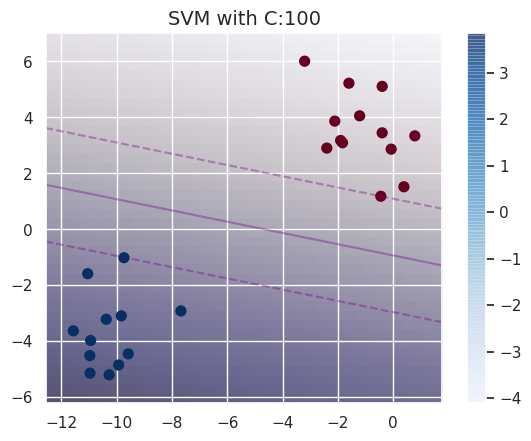

In [8]:
class SVM:
    def __init__(self,margin=1,C=1,lr=.0001,iteration=10**4):
        self.margin=margin
        self.C=C
        self.lr=lr
        self.w=None
        self.iteration=iteration
        
    def compute_hinge_loss(self):
        """ Compute Cost of slack variables """
        z=self.y*(self.X@self.w)
        hinge_loss=np.maximum(self.margin-z,0)
        idx=np.where(hinge_loss > 0)
        dh_loss=-self.y[idx].T@self.X[idx]
        return hinge_loss,dh_loss
    
    def svm_loss(self):
        # (1) Compute the hingle loss
        hinge_loss, dhinge_loss=self.compute_hinge_loss()
        # (2) Compute SVM loss: Hinge Loss + l2
        svm_loss=np.sum(self.w**2)+ self.C*hinge_loss.sum()        
        # (3) Compute the average the gradient of hinge loss
        dhinge_loss/=self.n
        dhinge_loss*=self.C
        # (4) Compute gradient of regularization
        dl2=2*self.w
        # (5) Compute derivative of the loss w.r.t. w.
        dw=dhinge_loss+dl2
        return svm_loss, dw
    
    def fit(self,X,y):
        # (1) Add ones to input.
        self.X=np.hstack((X,np.ones((len(X),1))))
        # (2) Add bias into weights.
        self.w=np.random.randn(self.X.shape[1])
        self.y=y
        # (3) number of data points.
        self.n=len(self.X)
        # Convert 0 to -1.
        y[y==0]=-1
        
        for i in range(self.iteration):
            #(4) Compute SVM loss and Compute derivative of loss w.r.t. w.
            svm_loss,dw=self.svm_loss()
            # (5) Update w in the negative direction of derivative.
            self.w-=self.lr*dw    
            # Gradient Cliping
            if i %(self.iteration//20)==0:
                print(f'Loss:{svm_loss:.5} ||w||_2={sum(self.w*self.w):.3f}, Acc:{(y==self.predict(X)).mean()}')
                
                if svm_loss==0:
                    print('ZERO loss')
                    break
        return self
    
    def decision_function(self,X):
        X=np.hstack((X,np.ones((len(X),1))))
        return X@self.w
    
    def predict(self,X):
        pred=(self.decision_function(X)>0)*1
        pred[pred==0]=-1
        return pred
    
    
    def plot_decision_boundary(self,X,y,plot_support_vector=False):
        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], c=y, s=50,cmap='RdBu')
        ax.set_title(f'SVM with C:{self.C}', size=14)
        
        xx_min,xy_min=X.min(axis=0)
        xx_max,xy_max=X.max(axis=0)

        # Visualization works perfectly
        xlim,ylim = (xx_min-1, xx_max+1), (xy_min-1, xy_max+1)
        xg = np.linspace(xlim[0], xlim[1], 60)
        yg = np.linspace(ylim[0], ylim[1], 40)
        xx, yy = np.meshgrid(xg, yg)
        Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T
        for label, color in enumerate(['red', 'blue']):
            Pm=self.decision_function(Xgrid)
            c=ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,cmap=color.title() + 's')
            ax.contour(xx, yy, Pm.reshape(xx.shape),levels=[-self.margin,0,self.margin],
                       colors=color,linestyles=['--', '-', '--'],alpha=0.2)
        fig.colorbar(c, ax=ax)
        ax.set(xlim=xlim, ylim=ylim)

        if plot_support_vector:
        
            P=self.decision_function(X)
            self.support_vectors_=X[(np.where((P <1.1) & (P >-1.1)))]
        
            plt.scatter(self.support_vectors_[:, 0],self.support_vectors_[:, 1],s=300, linewidth=2, facecolors='g',label='Support Vectors');

            pred=self.decision_function(X)
            for i in range(len(X)):
                if -1.1<pred[i]<1.1:
                    plt.annotate(f'  {pred[i]:.3},{y[i]}',xy=(X[i]))
            plt.legend()
        plt.show()
        
        
X, y = make_blobs(25, 2, centers=2, random_state=1, cluster_std=1.4)
y[y==0]=-1.0
y=y.astype(np.float64)
X=X.astype(np.float64)
svm=SVM(C=100).fit(X,y)
svm.plot_decision_boundary(X,y)

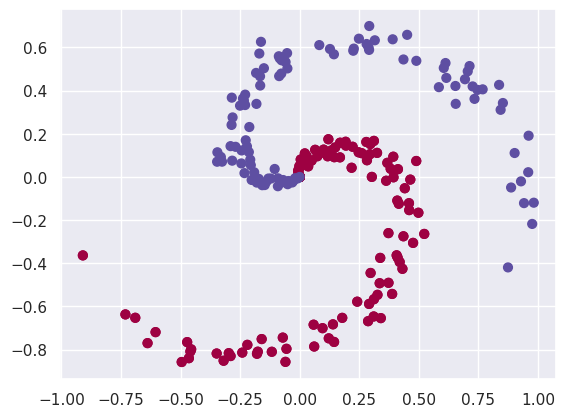

(200, 2) (200,)
float64 float64
Loss:2.2175e+04 ||w||_2=1.703, Acc:0.285
Loss:1.5192e+04 ||w||_2=1.654, Acc:0.535
Loss:1.2369e+04 ||w||_2=2.512, Acc:0.645
Loss:1.129e+04 ||w||_2=3.325, Acc:0.765
Loss:1.0896e+04 ||w||_2=3.871, Acc:0.755
Loss:1.0694e+04 ||w||_2=4.255, Acc:0.75
Loss:1.0594e+04 ||w||_2=4.537, Acc:0.745
Loss:1.0531e+04 ||w||_2=4.756, Acc:0.75
Loss:1.0501e+04 ||w||_2=4.886, Acc:0.75
Loss:1.0474e+04 ||w||_2=5.000, Acc:0.75
Loss:1.0457e+04 ||w||_2=5.077, Acc:0.755
Loss:1.0446e+04 ||w||_2=5.121, Acc:0.76
Loss:1.0437e+04 ||w||_2=5.162, Acc:0.76
Loss:1.0433e+04 ||w||_2=5.183, Acc:0.76
Loss:1.0432e+04 ||w||_2=5.185, Acc:0.76
Loss:1.0432e+04 ||w||_2=5.188, Acc:0.76
Loss:1.0431e+04 ||w||_2=5.190, Acc:0.76
Loss:1.0431e+04 ||w||_2=5.192, Acc:0.76
Loss:1.0431e+04 ||w||_2=5.194, Acc:0.76
Loss:1.043e+04 ||w||_2=5.196, Acc:0.76


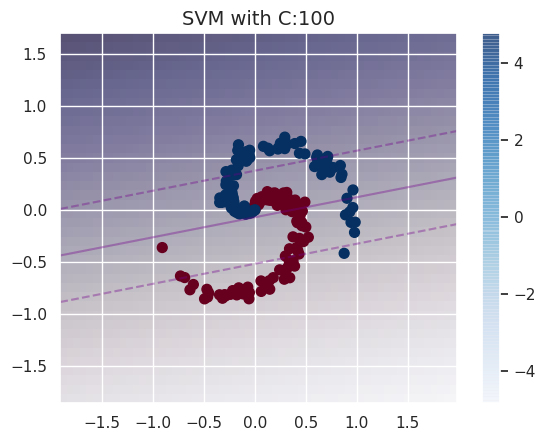

0.76

In [9]:
X,y=spiral_data_gen()
print(X.shape, y.shape)
print(X.dtype, y.dtype)
clr=SVM(C=100).fit(X,y)
clr.plot_decision_boundary(X,y) # No solution found
(clr.predict(X)==y).mean()

## $$ \text{Better performance than using hard constriants} $$

## $$ \text{Kernalization acts like a steroid on SVM} $$

# Multiclass Support Vector Machines and Kernels


Please watch invaluable lectures of [Kilian Weinberger](https://www.cs.cornell.edu/~kilian/)
+ [Machine Learning Lecture 14](https://www.youtube.com/watch?v=xpHQ6UhMlx4&list=PLl8OlHZGYOQ7bkVbuRthEsaLr7bONzbXS&index=14)
+ [Machine Learning Lecture 15](https://www.youtube.com/watch?v=FwYNPomeBBg&list=PLl8OlHZGYOQ7bkVbuRthEsaLr7bONzbXS&index=15)
+ [Machine Learning Lecture 22](https://www.youtube.com/watch?v=FgTQG2IozlM&list=PLl8OlHZGYOQ7bkVbuRthEsaLr7bONzbXS&index=22)
+ [Machine Learning Lecture 23](https://www.youtube.com/watch?v=erqL3y2es1I&list=PLl8OlHZGYOQ7bkVbuRthEsaLr7bONzbXS&index=23)











## SVM Dual Objective with Slack Variable

$$ min_{\alpha_1, \dots, \alpha_n} \frac{1}{2} \sum_i ^n \sum_j ^n \alpha_i \alpha_j y_i y_j K_{ij} - \sum_i ^n \alpha_i \\ \text{subject to } \\
\sum_i ^n \alpha_i y_i = 0 \;: \; \alpha_i \ge 0
$$
$$ w = \sum_i ^n \alpha_i y_i x_i $$
$$ b = y_i - \sum_j ^n \alpha_j y_j x_j^T x_i  \; \text{ for all } \alpha_i > 0$$

## SVM Dual Objective with Slack Variable


$$ min_{\alpha_1, \dots, \alpha_n} \frac{1}{2} \sum_i ^n \sum_j ^n \alpha_i \alpha_j y_i y_j K_{ij} - \sum_i ^n \alpha_i \\ \text{subject to } \\
\sum_i ^n \alpha_i y_i = 0 \;: \; \alpha_i \in [0,C]
$$
$$ w = \sum_i ^n \alpha_i y_i x_i $$
$$ b = y_i - \sum_j ^n \alpha_j y_j x_j^T x_i  \; \text{ for all } \alpha_i > 0$$

Langrangian Karush-Kuhn-Tucker (KKT) Dual Formulation. $K$ stands for __the kernel matrix.__

# Linear Kernel

$$ K_{i,j} = x_i ^t x_j$$

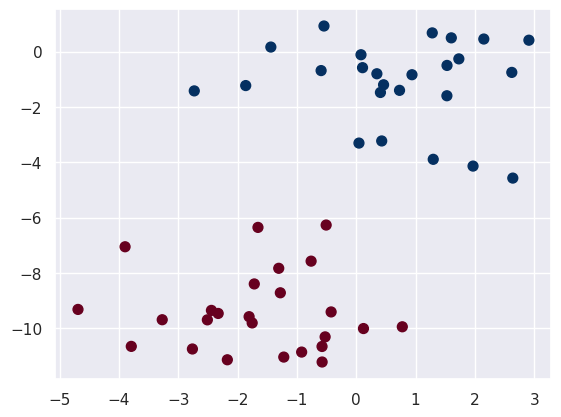

In [10]:
X, y = make_blobs(50, 2, centers=2, random_state=2, cluster_std=1.4)
y[y==0]=-1.0
y=y.astype(np.float64)
plt.scatter(X[:,0],X[:,1],c=y,s=50,cmap='RdBu')

# SVM RFB $\sigma=1$

In [12]:
class SVM_QP:
    """ Maximum margin classifier - Support Vector Machines 
    as a quadratic optimization problem
    
    min_{w,b}   ||w||_2 subject to \forall y_i (w^T x_i + b) >= 1
    """
    
    def __init__(self,kernel=linear_kernel,sigma=None,C=None):
        self.C=C
        self.kernel=kernel
        self.sigma=sigma
 
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Dot product between each and every pair of inputs
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if self.sigma:
                    K[i,j] = self.kernel(X[i], X[j],self.sigma)

        # Solves a quadratic program
        """
        minimize    (1/2)*a'*P*a + q'*a
        subject to  G*a <= h
                    A*a = b.
                    
        P = (\sum_i \sum_j a_i a_j y_i y_j x_i^T x_j) 
        q = -\sum_i x_i
        
        G= \forall i a_i >= 0 (NO SLACK)
        """
        P = cvxopt.matrix(np.outer(y,y) * K)
        # -|a|
        q= cvxopt.matrix(np.ones(n_samples) * -1)
        
        """ (1) Linear Constraint  : Inner product of alpha with labels should be 0 """ 
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        
        if self.C is None:
            # If there are no slack variables
            """ (2.1) Linear Constraint  : every alpha is positive """ 
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            # If there are slack variables
            """ (2.2) Linear Constraint  : every alpha is between 0 or C""" 
            G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        solution = cvxopt.solvers.qp(P, q, 
                                     G, h, 
                                     A, b)
        # Lagrange multipliers
        a = np.ravel(solution['x'])
        
        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print ("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
            
        if len(self.a)>0:
            self.b /= len(self.a)
    
        # Weight vector
        self.w = None
            
        return self

    def project(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                if self.sigma:
                    s += a * sv_y * self.kernel(X[i], sv,self.sigma)
                y_predict[i] = s
        return y_predict + self.b
    
    def predict(self, X):
        return np.sign(self.project(X))
    
    def plot_decision_boundary(self,X,y,plot_support_vector=False):
        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], c=y, s=50,cmap='RdBu')
        ax.set_title(f'SVM', size=14)
        
        xx_min,xy_min=X.min(axis=0)
        xx_max,xy_max=X.max(axis=0)

        # Visualization works perfectly
        xlim,ylim = (xx_min-1, xx_max+1), (xy_min-1, xy_max+1)
        xg = np.linspace(xlim[0], xlim[1], 60)
        yg = np.linspace(ylim[0], ylim[1], 40)
        xx, yy = np.meshgrid(xg, yg)
        Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T
        for label, color in enumerate(['red', 'blue']):
            Pm=self.project(Xgrid)
            c=ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,cmap=color.title() + 's')
            ax.contour(xx, yy, Pm.reshape(xx.shape),levels=[-1,0,1],
                       colors=color,linestyles=['--', '-', '--'],alpha=0.2)
        fig.colorbar(c, ax=ax)
        ax.set(xlim=xlim, ylim=ylim)

        if plot_support_vector:
            plt.scatter(self.sv[:, 0],self.sv[:, 1],s=300, linewidth=2, facecolors='g',label='Support Vectors');

            pred=self.project(X)
            for i in range(len(X)):
                if -1.1<pred[i]<1.1:
                    plt.annotate(f'  {pred[i]:.3},{y[i]}',xy=(X[i]))
            plt.legend()
        plt.show()
        return self

     pcost       dcost       gap    pres   dres
 0: -5.8241e+00 -1.7158e+01  1e+01  2e-16  1e+00
 1: -6.2975e+00 -7.4626e+00  1e+00  3e-16  2e-01
 2: -6.5879e+00 -6.8280e+00  2e-01  4e-16  3e-02
 3: -6.6658e+00 -6.6948e+00  3e-02  5e-16  8e-04
 4: -6.6784e+00 -6.6796e+00  1e-03  5e-16  9e-06
 5: -6.6791e+00 -6.6792e+00  2e-04  5e-16  1e-06
 6: -6.6792e+00 -6.6792e+00  2e-06  4e-16  1e-08
Optimal solution found.
29 support vectors out of 50 points


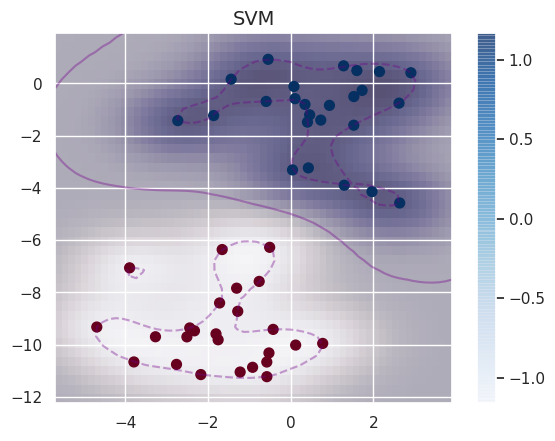

1.0

In [13]:
clr=SVM_QP(kernel=gaussian_kernel,sigma=1.0).fit(X,y).plot_decision_boundary(X,y)
(clr.predict(X)==y).mean()

# SVM RFB $\sigma=.5$

     pcost       dcost       gap    pres   dres
 0: -1.1344e+01 -3.0146e+01  2e+01  7e-16  2e+00
 1: -1.3003e+01 -1.4497e+01  1e+00  5e-16  2e-01
 2: -1.3607e+01 -1.3931e+01  3e-01  1e-15  4e-02
 3: -1.3669e+01 -1.3692e+01  2e-02  9e-16  5e-04
 4: -1.3677e+01 -1.3677e+01  7e-04  1e-15  4e-06
 5: -1.3677e+01 -1.3677e+01  1e-05  9e-16  5e-08
 6: -1.3677e+01 -1.3677e+01  2e-07  9e-16  5e-10
Optimal solution found.
41 support vectors out of 50 points


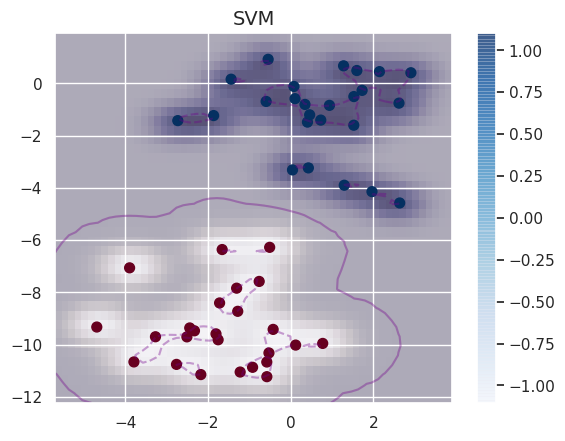

1.0

In [14]:
SVM_QP(kernel=gaussian_kernel,sigma=.5).fit(X,y).plot_decision_boundary(X,y)
(clr.predict(X)==y).mean()

# SVM RFB $\sigma=.01$

     pcost       dcost       gap    pres   dres
 0: -1.8750e+01 -4.3750e+01  2e+01  3e-16  2e+00
 1: -2.3595e+01 -2.3977e+01  4e-01  8e-16  2e-01
 2: -2.5000e+01 -2.5044e+01  4e-02  0e+00  6e-17
 3: -2.5000e+01 -2.5000e+01  4e-04  0e+00  2e-17
 4: -2.5000e+01 -2.5000e+01  4e-06  2e-15  9e-17
Optimal solution found.
50 support vectors out of 50 points


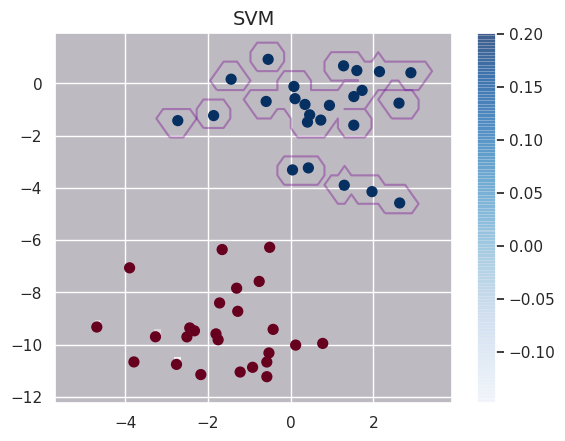

1.0

In [15]:
SVM_QP(kernel=gaussian_kernel,sigma=.01).fit(X,y).plot_decision_boundary(X,y)
(clr.predict(X)==y).mean()

# SVM RFB $\sigma=10$

     pcost       dcost       gap    pres   dres
 0: -6.8568e+00 -1.8918e+01  1e+02  8e+00  2e+00
 1: -9.0771e+00 -2.1345e+01  3e+01  2e+00  5e-01
 2: -1.7083e+01 -2.8323e+01  3e+01  1e+00  3e-01
 3: -2.1494e+01 -2.5354e+01  8e+00  4e-01  9e-02
 4: -2.2870e+01 -2.4634e+01  2e+00  3e-02  7e-03
 5: -2.4308e+01 -2.4343e+01  4e-02  2e-04  4e-05
 6: -2.4338e+01 -2.4338e+01  4e-04  2e-06  4e-07
 7: -2.4338e+01 -2.4338e+01  4e-06  2e-08  4e-09
Optimal solution found.
3 support vectors out of 50 points


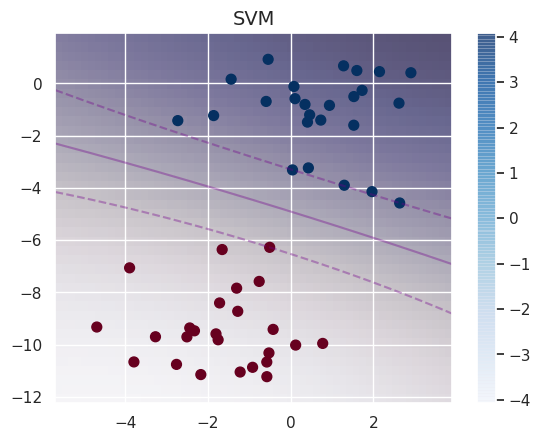

1.0

In [16]:
SVM_QP(kernel=gaussian_kernel,sigma=10).fit(X,y).plot_decision_boundary(X,y)
(clr.predict(X)==y).mean()

# MULTICLASS SVMs

$$ \mathcal D = {(\mathcal x_i , y_i)}$$
where 
1. $\mathbf{x}_i \in \mathbb R ^d$
2. $y_i \in [1,2,\dots,k]$

$$ \hat y = argmax_{m \in [k]} \mathbf{w}^T _m \mathbf{x},$$
where 
1. $\mathbf{w}_m \in \mathbb R ^d$ a prototype representing the $m^{th}$ class  
2. $\mathbf{w}^T _m \mathbf{x}$ represents the score of the $m^{th}$ class w.r.t. $\mathbf x$.





### Optimization problem
$$ minimize_{\mathbf w_1 , \dots , \mathbf w_k} \frac{1}{2} \sum_m ^k || \mathbf w_m |||^2 + C \sum_i ^n \big[ 1 + max_{m\not=y_i} \mathbf{w}^T _m \mathbf{x}_i - \mathbf{w}^T _{y_i} \mathbf{x}_i \big]_+ $$
where $C>0$ 

1. If the score of the correct class is larger than the scroe of the "closest"class by at least 1, we suffer no loss.



### Dual Formulation



$$ minimize_{\mathbf \alpha} \; f(\mathbf \alpha) = \frac{1}{2} \sum_m ^k || \mathbf w _m (\mathbf \alpha)||^2 + \sum_i ^n \sum_m ^k \Delta_i ^m \alpha_i ^m $$
subject to
1. $ \alpha_i ^m \le C_i ^m \; \forall i \in [n] \; \forall m \in [k]$.
2. $\sum_m ^k \alpha_i ^m = 0 \; \forall i \in [n]$



$C_i ^m = C$ if $m=y_i$, otherwise $C_i^m=0$

$ \Delta_i ^m = 0 $ if $m =y_i$ and 1 otherwise

#### The primal-dual relationship is given by

$$ \mathbf w _m (\mathbf \alpha) = \sum_i ^n \alpha_i ^m \mathbf x_i \; \; \forall m \in [k]$$

# Derivative w.r.t. $\mathbf \alpha$



$$ g_i ^m = \frac{\partial f}{ \partial \alpha_i ^m} = \mathbf w_m (\alpha)^T \mathbf x_i + \Delta_i ^m \; \; \forall i \in [n] \; \forall m \in [k]$$

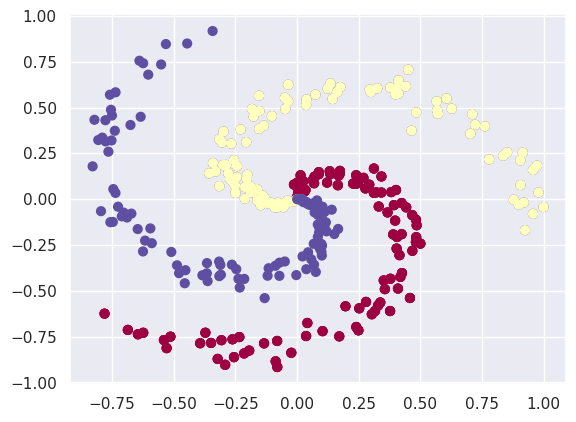

(300, 2) (300,)
float64 float64


In [17]:
X,y=spiral_data_gen(K=3)
print(X.shape, y.shape)
print(X.dtype, y.dtype)